In [14]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import SDMolSupplier
import numpy as np
import torch

In [9]:
def parse_ligand_sdf(ligand_path):
    mol = Chem.MolFromMolFile(str(ligand_path))
    if mol is None:
        print("no mol found")
    return mol

In [10]:
ligand_file = "../../../Downloads/refined-set/1a1e/1a1e_ligand.sdf"

In [11]:
ligand = parse_ligand_sdf(ligand_file)

[11:19:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


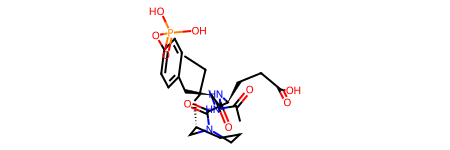

In [12]:
ligand

In [13]:
COMMON_ATOMS = ["H", "C", "N", "O", "F", "P", "S", "Cl", "Br", "I", "B", "Si", "Se"]
ATOM_MAP = {a: i for i, a in enumerate(COMMON_ATOMS)}

HYBRIDIZATION_MAP = {
    Chem.rdchem.HybridizationType.SP: 0,
    Chem.rdchem.HybridizationType.SP2: 1,
    Chem.rdchem.HybridizationType.SP3: 2,
    Chem.rdchem.HybridizationType.SP3D: 3,
    Chem.rdchem.HybridizationType.SP3D2: 4
}

def one_hot(x, choices):
    out = [0]*len(choices)
    if x in choices:
        out[choices.index(x)] = 1
    return out

def atom_to_feature_vector(atom):
    symbol = atom.GetSymbol()
    atom_onehot = one_hot(symbol, COMMON_ATOMS)
    degree = atom.GetDegree()
    formal_charge = atom.GetFormalCharge()
    num_hs = atom.GetTotalNumHs()
    aromatic = 1 if atom.GetIsAromatic() else 0
    hybrid = HYBRIDIZATION_MAP.get(atom.GetHybridization(), -1)
    hybrid_oh = one_hot(hybrid, list(range(len(HYBRIDIZATION_MAP)+1)))  
    vec = atom_onehot + [degree, formal_charge, num_hs, aromatic] + hybrid_oh
    return np.array(vec, dtype=np.float32)

[11:21:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


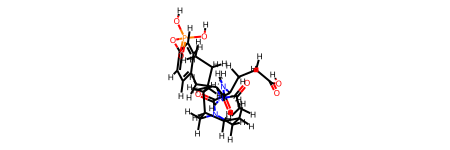

In [21]:
supplier = SDMolSupplier(ligand_file, removeHs=False)
mol = supplier[0]
mol

In [23]:
num_atoms = mol.GetNumAtoms()

In [24]:
num_atoms

76

In [26]:
node_feats = np.vstack([atom_to_feature_vector(a) for a in mol.GetAtoms()]) if num_atoms > 0 else np.zeros((0, len(COMMON_ATOMS)+5+len(HYBRIDIZATION_MAP)+1), dtype=np.float32)

In [27]:
node_feats

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], shape=(76, 23), dtype=float32)

In [36]:
edges = []
edge_attrs = []
for bond in mol.GetBonds():
    i = bond.GetBeginAtomIdx()
    j = bond.GetEndAtomIdx()
    bt = bond.GetBondType()
    is_aromatic = 1 if bond.GetIsAromatic() else 0
    
    bt_oh = [
        1 if bt == Chem.rdchem.BondType.SINGLE else 0,
        1 if bt == Chem.rdchem.BondType.DOUBLE else 0,
        1 if bt == Chem.rdchem.BondType.TRIPLE else 0,
        1 if bt == Chem.rdchem.BondType.AROMATIC else 0,
    ]
    edge_attr = bt_oh + [is_aromatic]
    edges.append((i, j))
    edges.append((j, i))
    edge_attrs.append(edge_attr)
    edge_attrs.append(edge_attr)
    
if len(edges) > 0:
    edge_index = np.array(edges, dtype=np.int64).T  # [2, E]
    edge_attr = np.array(edge_attrs, dtype=np.float32)
else:
    edge_index = np.zeros((2,0), dtype=np.int64)
    edge_attr = np.zeros((0,5), dtype=np.float32)

In [38]:
edge_attr

array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1.],
       [0., 0., 0., 1., 1.],
       [0., 0., 0., 1., 1.],
       [0., 0., 0., 1., 1.],
       [0., 0., 0., 1., 1.],
       [0., 0., 0., 1., 1.],
       [0., 0., 0., 1., 1.],
       [0., 0., 0., 1., 1.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1.],
       [0., 0., 0., 1., 1.],
       [0., 0., 0., 1., 1.],
       [0., 0., 0., 1., 1.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1.

In [41]:
pos = np.zeros((num_atoms, 3), dtype=np.float32)
if mol.GetNumConformers() > 0:
    conf = mol.GetConformer(0)
    for i in range(num_atoms):
        p = conf.GetAtomPosition(i)
        pos[i] = [p.x, p.y, p.z]
else:
    try:
        AllChem.EmbedMolecule(mol, randomSeed=0xf00d)
        conf = mol.GetConformer()
        for i in range(num_atoms):
            p = conf.GetAtomPosition(i)
            pos[i] = [p.x, p.y, p.z]
    except Exception:
        pass

In [42]:
pos

array([[ 43.293 ,  -8.128 ,  37.55  ],
       [ 44.067 ,  -7.186 ,  37.788 ],
       [ 43.519 ,  -9.01  ,  36.332 ],
       [ 42.169 ,  -8.311 ,  38.208 ],
       [ 41.875 ,  -7.504 ,  39.354 ],
       [ 42.397 ,  -8.189 ,  40.59  ],
       [ 42.867 ,  -9.329 ,  40.591 ],
       [ 40.391 ,  -7.291 ,  39.374 ],
       [ 40.02  ,  -6.467 ,  38.165 ],
       [ 39.433 ,  -7.066 ,  37.071 ],
       [ 40.203 ,  -5.089 ,  38.163 ],
       [ 39.023 ,  -6.299 ,  35.991 ],
       [ 39.795 ,  -4.303 ,  37.08  ],
       [ 39.197 ,  -4.913 ,  35.992 ],
       [ 38.714 ,  -4.103 ,  34.899 ],
       [ 39.563 ,  -3.959 ,  33.541 ],
       [ 39.296 ,  -5.223 ,  32.855 ],
       [ 38.986 ,  -2.729 ,  32.92  ],
       [ 40.975 ,  -3.833 ,  34.058 ],
       [ 42.346 ,  -7.452 ,  41.662 ],
       [ 42.821 ,  -7.926 ,  42.925 ],
       [ 41.649 ,  -8.473 ,  43.728 ],
       [ 40.525 ,  -7.995 ,  43.504 ],
       [ 43.463 ,  -6.759 ,  43.607 ],
       [ 44.713 ,  -6.254 ,  42.92  ],
       [ 45.85  ,  -7.203

In [44]:
node_feats

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], shape=(76, 23), dtype=float32)

In [48]:
node_feats = torch.tensor(node_feats, dtype=torch.float32)
edge_index = torch.tensor(edge_index, dtype=torch.long)
edge_attr = torch.tensor(edge_attr, dtype=torch.float32)
pos = torch.tensor(pos, dtype=torch.float32)

/var/folders/dj/gxdb6r9x1zb81v5fqcfm4m5c0000gn/T/ipykernel_25680/583692440.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  node_feats = torch.tensor(node_feats, dtype=torch.float32)
/var/folders/dj/gxdb6r9x1zb81v5fqcfm4m5c0000gn/T/ipykernel_25680/583692440.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edge_index, dtype=torch.long)
